In [1]:
import xarray as xr
import os
import numpy as np
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

In [25]:
data_dir = "/global/cfs/projectdirs/m4259/ecucuzzella/soma_ppe_data/gm/output_0/"
longTermData = "/global/cfs/cdirs/m4259/snarayan/soma_gm_long/ocean/soma/32km/ensemble_long/forward_16/analysis_members/mpaso.hist.am.timeSeriesStatsDaily.0007-01-01.nc"
mesh_path ="/global/cfs/projectdirs/m4259/ecucuzzella/soma_ppe_data/gm/initial_state/mesh.nc"
data_name = "output.0003-01-01_00.00.00.nc"

file_path = os.path.join(data_dir, data_name)

mesh = xr.open_dataset(longTermData)
print(mesh)
# lat_radian = mesh["latCell"].values
# depths = mesh["bottom"].values
# print(depths)
print(list(mesh.keys()))
# print(mesh.variables["latCell"].values)

#file_path_long_term = os.path.join(longTermDataDir, longTermName)
#Ds = xr.open_dataset(file_path_long_term)

<xarray.Dataset> Size: 266MB
Dimensions:                                  (Time: 26, bnds: 2, nCells: 8521,
                                              nVertLevels: 60)
Coordinates:
  * Time                                     (Time) object 208B 0007-01-08 12...
Dimensions without coordinates: bnds, nCells, nVertLevels
Data variables:
    xtime                                    (Time) |S64 2kB ...
    timeDaily_counter                        (Time) int32 104B ...
    xtime_startDaily                         (Time) |S64 2kB ...
    xtime_endDaily                           (Time) |S64 2kB ...
    Time_bnds                                (Time, bnds) object 416B ...
    timeDaily_avg_layerThickness             (Time, nCells, nVertLevels) float32 53MB ...
    timeDaily_avg_velocityZonal              (Time, nCells, nVertLevels) float32 53MB ...
    timeDaily_avg_velocityMeridional         (Time, nCells, nVertLevels) float32 53MB ...
    timeDaily_avg_activeTracers_temperature  (Time, nCe

In [10]:
area = mesh.areaCell.values

forward_KE_list = []
kappa_gm = []
for k in tqdm(range(1, 15)):
    longTermDataDir = f"/global/cfs/projectdirs/m4259/snarayan/soma_gm_long/ocean/soma/32km/ensemble_long/forward_{k}/"
    namelist_file = "namelist.ocean"
    namelist_path = os.path.join(longTermDataDir, namelist_file)
    GM_pattern = "config_GM_constant_kappa = (\d+.\d+)"
    namelist = open(namelist_path, "r")
    kappa = float(re.search(GM_pattern, namelist.read()).group(1))
    kappa_gm.append(kappa)
    
    KEa_list = []
    for i in range(1, 23):
        longTermName = f"analysis_members/mpaso.hist.am.timeSeriesStatsDaily.00{i:02}-01-01.nc"
        
        file_path_long_term = os.path.join(longTermDataDir, longTermName)
        Ds = xr.open_dataset(file_path_long_term)
        U = Ds.timeDaily_avg_velocityZonal.values
        V = Ds.timeDaily_avg_velocityMeridional.values
        LT = Ds.timeDaily_avg_layerThickness.values

        KEav = np.nansum(area[np.newaxis,:,np.newaxis]*LT*(U**2+V**2),axis=(1,2)) / np.nansum(np.nansum(area[np.newaxis,:,np.newaxis]*LT))
        KEa_list.append(KEav)

    KEav = np.concatenate(KEa_list, axis=0)
    forward_KE_list.append(KEav)


100%|██████████| 14/14 [04:20<00:00, 18.61s/it]


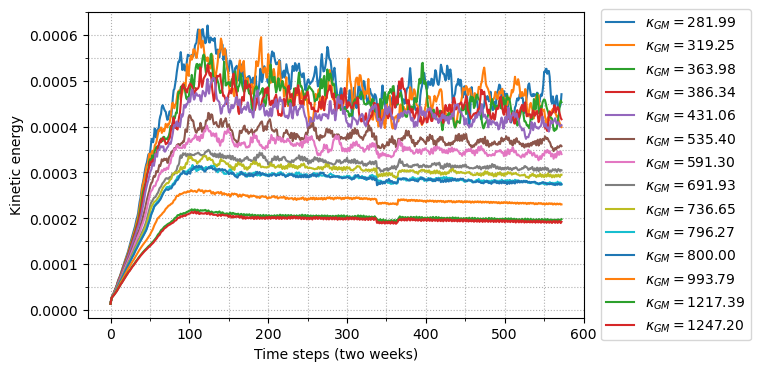

In [15]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.rcParams['font.size']=10
fig, ax = plt.subplots()
ax.set_box_aspect(1/1.62)
sorted_idx = np.argsort(kappa_gm)
kappa_gm = np.array(kappa_gm)[sorted_idx]
forward_KE_list = np.array(forward_KE_list)[sorted_idx]
for gm, KEav in zip(kappa_gm, forward_KE_list):
    ax.plot(KEav, label=rf"$\kappa_{{GM}} = {gm:.2f}$")
ax.set_xlabel("Time steps (two weeks)")
ax.set_ylabel("Kinetic energy")
ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.yaxis.set_minor_locator(MultipleLocator(0.00005))
ax.grid(which="both", linestyle="dotted")
ax.legend(bbox_to_anchor=(1.02, 1.03))
fig.savefig('kinetic_energy.pdf', format='pdf', bbox_inches='tight')


In [55]:
# plot temeperature/salinity progression with time (take volume average)
def volume_avg(var_name):
    area = mesh.areaCell.values
    
    forward_var_list = []
    kappa_gm = []
    for k in tqdm(range(1, 2)):
        longTermDataDir = f"/global/cfs/projectdirs/m4259/snarayan/soma_gm_long/ocean/soma/32km/ensemble_long/forward_{k}/"
        namelist_file = "namelist.ocean"
        namelist_path = os.path.join(longTermDataDir, namelist_file)
        GM_pattern = "config_GM_constant_kappa = (\d+.\d+)"
        namelist = open(namelist_path, "r")
        kappa = float(re.search(GM_pattern, namelist.read()).group(1))
        kappa_gm.append(kappa)

        Var_av_list = []
        for i in range(1, 23):
            longTermName = f"analysis_members/mpaso.hist.am.timeSeriesStatsDaily.00{i:02}-01-01.nc"

            file_path_long_term = os.path.join(longTermDataDir, longTermName)
            Ds = xr.open_dataset(file_path_long_term)

            Temp = Ds.timeDaily_avg_activeTracers_temperature.values
            Sal = Ds.timeDaily_avg_activeTracers_salinity.values
            U = Ds.timeDaily_avg_velocityZonal.values
            V = Ds.timeDaily_avg_velocityMeridional.values
            LT = Ds.timeDaily_avg_layerThickness.values

            # KEav = np.nansum(area[np.newaxis,:,np.newaxis]*LT*(U**2+V**2),axis=(1,2)) / np.nansum(np.nansum(area[np.newaxis,:,np.newaxis]*LT))
            # KEa_list.append(KEav)
            if var_name == "temperature":
                print(Temp)
                Var_av = np.nansum(area[np.newaxis,:,np.newaxis]*LT*Temp,axis=(1,2)) / np.nansum(np.nansum(area[np.newaxis,:,np.newaxis]*LT))

            elif var_name == "salinity":
                Var_av = np.nansum(area[np.newaxis,:,np.newaxis]*LT*Sal, axis=(1,2)) / np.nansum(np.nansum(area[np.newaxis,:,np.newaxis]*LT))
            elif var_name == "kinetic":
                Var_av = np.nansum(area[np.newaxis,:,np.newaxis]*LT*(U**2 + V**2),axis=(1,2)) / np.nansum(np.nansum(area[np.newaxis,:,np.newaxis]*LT))
            else:
                raise ValueError(f"{var_name} not recoganized")
            Var_av_list.append(Var_av)
            
        Var_av = np.concatenate(Var_av_list, axis=0)
        forward_var_list.append(Var_av)
    return forward_var_list, kappa_gm
    
                                
                                

In [56]:
def plot_progression(var_list, param_list, var_name="Temperature"):
    plt.rcParams['font.size']=10
    fig, ax = plt.subplots()
    ax.set_box_aspect(1/1.62)
    sorted_idx = np.argsort(param_list)
    param_list = np.array(param_list)[sorted_idx]
    var_list = np.array(var_list)[sorted_idx]
    for gm, var in zip(param_list, var_list):
        ax.plot(var, label=rf"$\kappa_{{GM}} = {gm:.2f}$")
    ax.set_xlabel("Time steps (two weeks)")
    ax.set_ylabel(f"{var_name}")
    # ax.xaxis.set_minor_locator(MultipleLocator(50))
    # ax.yaxis.set_minor_locator(MultipleLocator(0.00005))
    ax.grid(which="both", linestyle="dotted")
    ax.legend(bbox_to_anchor=(1.02, 1))
    fig.savefig(f'{var_name}_volmeAvg.pdf', format='pdf', bbox_inches='tight')
    

100%|██████████| 14/14 [06:46<00:00, 29.02s/it]


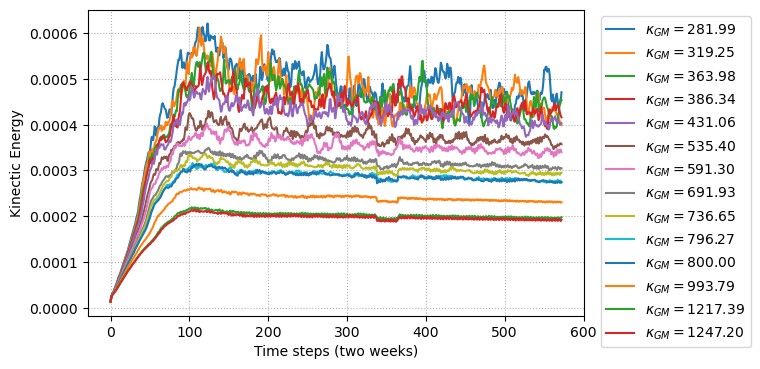

In [41]:
temp_list, param_list = volume_avg("kinetic")
plot_progression(temp_list, param_list, "Kinectic Energy" )

  0%|          | 0/1 [00:00<?, ?it/s]

[[[19.18486    19.18474    19.184532   ...  0.11360736  0.06832229
           nan]
  [19.442116   19.441397   19.43977    ...         nan         nan
           nan]
  [19.603771   19.603157   19.60048    ...         nan         nan
           nan]
  ...
  [19.09816    19.097563   19.096504   ...         nan         nan
           nan]
  [19.135202   19.134497   19.133205   ...         nan         nan
           nan]
  [19.116453   19.115938   19.11502    ...         nan         nan
           nan]]

 [[19.014101   19.01398    19.013794   ...  0.11344723  0.06859536
           nan]
  [19.45919    19.458754   19.457947   ...         nan         nan
           nan]
  [19.507027   19.507084   19.507133   ...         nan         nan
           nan]
  ...
  [18.942945   18.942604   18.942053   ...         nan         nan
           nan]
  [18.96124    18.960926   18.960417   ...         nan         nan
           nan]
  [18.944023   18.943651   18.943077   ...         nan         nan
      

100%|██████████| 1/1 [00:19<00:00, 19.31s/it]


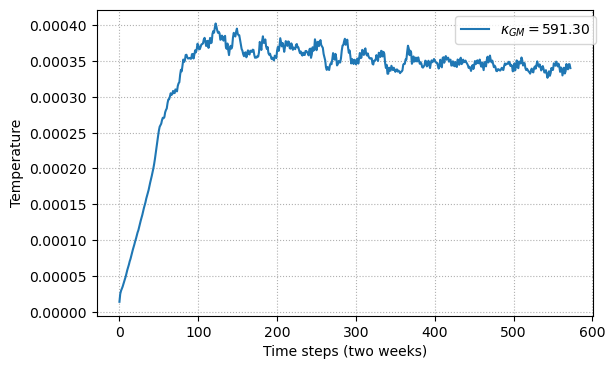

In [57]:
sal_list, param_list = volume_avg("temperature")
plot_progression(temp_list, param_list, "Temperature" )

# Converting mesh to graph
now we need to convert the mesh representation (3D) to a graph where the nodes are the mesh cells and edges indicate the connectivity between mesh cells.

The `graph.info` file in `initial_state` folder for each simulation setup provides the correct converted graph information (from MPAS tools). 
Therefore, we should use this information to construct graph.

The graph file only contains the connectivity information about the horizontal planes. To account for the vertical connectivity, we
simply connect the nodes that are directly above and below to each other.

In [6]:
# load the graph.info containing the connectivity information
import networkx as nx

# Initialize an empty graph
G = nx.Graph() # undirected
graph_dir = "/global/cfs/projectdirs/m4259/ecucuzzella/soma_ppe_data/gm/initial_state/"
graph_path = os.path.join(graph_dir, "graph.info")
# Read the graph.info file
with open(graph_path, 'r') as f:
    lines = f.readlines()

# First line contains the number of nodes and edges
num_nodes, num_edges = map(int, lines[0].split())

print(lines[1])
print(lines[-1])
print(len(lines))

print(f"num nodes {num_nodes}, num edge {num_edges}")

2129 2130 2131 2126 2127 2128 

5311 5310 2124 8520 8519 2125 

8522
num nodes 8521, num edge 25228


In [7]:
num_layers = 60
                

for n_id in range(num_nodes):
    node_idx = n_id + layer_id * num_nodes 
    G.add_node(node_idx)
    nei_nodes = map(int, lines[1 + n_id].split())

    for nei in nei_nodes:
        nei_idx = nei + layer_id * num_nodes - 1 # reset to 0 indexing
        G.add_edge(node_idx, nei_idx)
        
        
    # # add vertical connection
    # if layer_id > 0:
    #     upper_nodes = np.arange(num_nodes) + (layer_id - 1) * num_nodes
    #     lower_nodes = np.arange(num_nodes) + layer_id * num_nodes
    #     for up_n, low_n in zip(upper_nodes, lower_nodes):
    #         assert low_n - up_n == num_nodes
    #         G.add_edge(up_n, low_n)



In [10]:
# 
print(G.number_of_nodes())
print(G.number_of_edges())

# save the adj_matrix
from scipy import sparse
adj_matrix = nx.adjacency_matrix(G)
sparse.save_npz('adjacency_matrix_horizontal.npz', adj_matrix)

8521
25228


## Assign variable values to graph
Now that we created the graph, we can assign the variable values to the graph nodes
Each variable at a time instance has the shape of `(num_nodes, num_layers)`. To match the node index in the graph, we first need to reshape the array to (num_nodes, )

In [14]:
longTermDataDir = "/global/cfs/projectdirs/m4259/snarayan/soma_gm_long/ocean/soma/32km/ensemble_long/forward_1/analysis_members/"

data_name = "output.0003-01-01_00.00.00.nc"

filename = "mpaso.hist.am.timeSeriesStatsDaily.0001-01-01.nc"

file_path = os.path.join(longTermDataDir, filename)
Ds = xr.open_dataset(file_path)


In [15]:
temperature = Ds.timeDaily_avg_activeTracers_temperature.values
T, N, L = temperature.shape
print(temperature.shape)
temperature = temperature.reshape(T, N * L, order='F') # making sure the columns are concat together
print(temperature.shape)

(26, 8521, 60)
(26, 511260)


Now that the values are matching with the nodes, we need to remove the nodes contaning NaN values and to form the "bowl" shape of the domain

In [72]:
temperature = np.array(temperature)
valid_mask = ~np.isnan(temperature[0, :])
print(temperature.min(), temperature[0, -1])
print(valid_mask.sum())

nan nan
433502


with taking out the NaN nodes, the number of nodes reduces to 433502 (from 511260).

Now we need to remove these nodes from the graph.

In [17]:
nan_idx = np.argwhere(np.isnan(temperature[0,:])).squeeze()
print(nan_idx.shape)

print(G.number_of_nodes())
# remove these nan nodes
G.remove_nodes_from(list(nan_idx))
print(G.number_of_nodes())
print(G.number_of_edges())

(77758,)
433502
433502
1707133


In [86]:
# save the graph as adj matrix


In [ ]:
# now save all the variables after applying the mask